# Nuclear Magnetic Resonance

Nuclear magnetic resonance spectroscopy (NMR) is a power analytical tool in typically used for molecule identification. The values are often predicted with ab initio means to increase confidence in identification. To predict chemical shifts and spin couplings, we require, at minimum, a geometry. ISiCLE takes these inputs and can sequentially generate conformers and DFT optimized geometries to obtain Boltzmann-weighted NMR chemical shift values.

## Example Chemical Shift Calculation
For an example NMR calculation, we load mol file containing dimethylglycine, which instantiates and ISiCLE Geometry object.

/Users/jyst649/anaconda3/envs/isicle/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


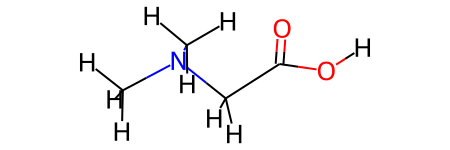

In [1]:
import isicle

geom = isicle.load('dimethylglycine.mol')
geom = geom.initial_optimize(embed=True)

geom.mol

### Conformational Ensembles
We use xtb's Conformer Rotamer Ensemble Sampling Tool, CREST to predict conformational ensembles. CREST is already a simple to use standalone command line tool, here we have created a Python function to call upon some tools CREST has made available followed by data parsed out from CREST output.

For example, here we generate conformers in water using a 3 kcal/mol energy window using the GFF forcefield.

In [2]:
conformer = geom.md(forcefield='gff',
                    ewin = 3,
                    task = 'conformer',
                    charge = geom.get_formal_charge(),
                    solvation = 'water',
                    processes = 4)

In [4]:
isicle.io.save('nmr_conformers.joblib', conformer)
conformer.charge = 0

conformer.get_structures()

[<isicle.geometry.XYZGeometry object at 0x10a1740a0>, <isicle.geometry.XYZGeometry object at 0x10a174c10>, <isicle.geometry.XYZGeometry object at 0x1a55b0250>, <isicle.geometry.XYZGeometry object at 0x1a55b0490>, <isicle.geometry.XYZGeometry object at 0x1a55b0040>, <isicle.geometry.XYZGeometry object at 0x1a55b03d0>, <isicle.geometry.XYZGeometry object at 0x1a55b0340>, <isicle.geometry.XYZGeometry object at 0x1a55b03a0>, <isicle.geometry.XYZGeometry object at 0x1a55b0370>, <isicle.geometry.XYZGeometry object at 0x1a55b0f40>, <isicle.geometry.XYZGeometry object at 0x1a55b0520>, <isicle.geometry.XYZGeometry object at 0x1a55b01f0>, <isicle.geometry.XYZGeometry object at 0x1a55b0f10>, <isicle.geometry.XYZGeometry object at 0x1a55b0460>, <isicle.geometry.XYZGeometry object at 0x1a55b0070>, <isicle.geometry.XYZGeometry object at 0x10a190580>, <isicle.geometry.XYZGeometry object at 0x10a190c40>, <isicle.geometry.XYZGeometry object at 0x10a190520>, <isicle.geometry.XYZGeometry object at 0x10a1

The output `conformer` is saved in `nmr_conformers.joblib`. Each ISiCLE XTBWrapper object contains the history, the contents of the output file, parsed timing information and a list of conformers found by CREST that have been converted into ISiCLE XYZGeometry objects. 

### Density Functional Theory Calculations

We now calculate DFT single point energies for each conformer using open-source quantum chemical software, NWChem. The `dft` function generates the NWChem input file using the ISiCLE Geometry object and specifications for the DFT calculations. Specifications are customizable to any functional or basis set available in NWChem, but defaults are set to B3LYP and 6-31g*, respectively.

Here we calculate the single point energies for each conformer using the hybrid functional, B3LYP, and split valence, double zeta basis set, 6-31+G**, and COSMO implicit solvation for water. For brevity, we only calculate the chemical shifts and spin of the lowest energy conformer.

In [5]:
geom = conformer.geom[0]

dft = geom.dft(tasks=['optimize', 'shielding'],
                    functional='B3LYP',
                    basis_set='6-31g*',
                    ao_basis='cartesian',
                    charge=conformer.charge,
                    solvent='h2o',
                    gas=False,
                    max_iter=150,
                    mem_global=1600,
                    mem_heap=600,
                    mem_stack=1000,
                    scratch_dir='/tmp',
                    processes=4,
                    command='nwchem')


In [6]:
isicle.io.save('nmr_dft.joblib', dft)
dft.get_structure()

`dft` is an ISiCLE NWChemWrapper object of the DFT calculation of the selected conformer, in this case we have chosen the structure with the lowest energy. An NWChemWrapper object contains the optimized geometry, as well as parsed information from the NWChem output file, including chemical shielding tensors, electronic energy, Mulliken charges, timing information and structural connectivity. Results from the above script is saved in `nmr_dft.joblib` and can be viewed below.

### Converting Chemical Shielding Tensors to Chemical Shifts
To obtain our final chemical values, we convert the shielding tensors into chemical shifts. This is accomplished using the `transform` function in the `conformers` module, which allows a value or a list of values to be linearly transformed using a provided slope and y-intercept value. Here we use values from the CHESHIRE Chemical Shift Repository.

In [11]:
isicle.conformers.transform(dft.shielding['shielding'], 
                            m={'H':-0.9921, 'C':-0.9816}, 
                            b={'H': 32.2773, 'C':180.4295}, 
                            atom=dft.shielding['atom'],
                            index=dft.shielding['index'])

,value,index,atom,new_value
7,29.3013,8,H,3.207480
8,29.4321,9,H,3.077714
9,28.4951,10,H,4.007311
10,29.3009,11,H,3.207877
11,29.4313,12,H,3.078507
12,28.4928,13,H,4.009593
13,28.1562,14,H,4.343534
14,28.1560,15,H,4.343732
15,25.9370,16,H,6.545202
0,150.3981,1,C,32.798725


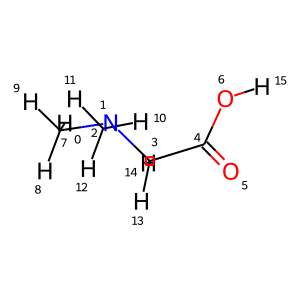

In [12]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
geom.mol

Taking the chemical shifts of dimethylglycine from Human Metabolome Database, HMDB0000092, the average error is 0.10 and 15.1 ppm for proton and carbon chemical shift predictions. The framework to do an automated comparison between experimental and calculated values is not currently available in ISiCLE 2.0, but is in the plans for future updates.

## Boltzmann Weighting Chemical Shift Values
Though we only calculcate chemical shifts for one conformer in this tutorial, it is possible to Boltzmann weight chemical shifts if multiple conformers are considered. To obtain our Boltzmann weighted chemical shift values, we Boltzmann average across the different conformers by their DFT energies. This is accomplished using the `conformers` module. Here we generate a pseudo-"conformer ensemble" by duplicating the `dft` object in a list. We can then transform the boltzmann-weighted chemical shielding values to chemical shifts using the `transform` function in the `conformers` module, as shown in the previous example.

In [3]:
dfts=[dft,dft]

boltzmann = {}

dft_energies = []
shift_values = []
atom = []
index = []

for conformer in dfts:
    for shift in dft.shielding['shielding']:
        dft_energies.append(dft.energy)
        shift_values.append(shift)
    for atom_type in dft.shielding['atom']:
        atom.append(atom_type)
    for idx in dft.shielding['index']:
        index.append(idx)

res = isicle.conformers.boltzmann(shift_values, dft_energies, index=index, atom=atom)
print(res)

      index      mean  std  n
0    (1, C)  149.0905  0.0  2
1    (2, N)  235.8028  0.0  2
2    (3, C)  149.0902  0.0  2
3    (4, C)  135.2399  0.0  2
4    (5, C)   29.0039  0.0  2
5    (6, O)  -63.3548  0.0  2
6    (7, O)  137.3212  0.0  2
7    (8, H)   29.9966  0.0  2
8    (9, H)   30.1020  0.0  2
9   (10, H)   29.0379  0.0  2
10  (11, H)   29.9966  0.0  2
11  (12, H)   30.1011  0.0  2
12  (13, H)   29.0365  0.0  2
13  (14, H)   28.8895  0.0  2
14  (15, H)   28.8894  0.0  2
15  (16, H)   26.9227  0.0  2
